<a href="https://colab.research.google.com/github/sebasruggero/analisis_transporte_catamarca/blob/main/An%C3%A1lisis_Catamarca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![img](https://www.argentina.gob.ar/sites/default/files/min_transporte.png)
# Subsecretaria de Proyectos Estratégicos y Desarrollo Tecnológico
## Análisis de Transacciones SUBE Ciudad San Fernando del Valle de Catamarca

In [ ]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
% pip install geopandas
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive


In [19]:
##  Importamos las librerias

import pandas as pd
import io
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import csv
import folium
from folium import plugins
from folium.plugins import HeatMap


## Variables Color
MAGENTA = "#6C3483"
GREEN = "#239B56"
BLUE = "#5DADE2"


In [28]:
## Importamos la data
url = 'https://raw.githubusercontent.com/sebasruggero/analisis_transporte_catamarca/main/cata.csv'

df = pd.read_csv(url)

In [29]:
## Cambiamos el tipo de dato a Datetime
df['FECHATRX'] = pd.to_datetime(df['FECHATRX'],errors='coerce') 

## Pasamos los float a 3 decimales
pd.set_option('display.float_format', lambda x: '%.3f' % x) ## Seteamos 3 digidos decimales

[Text(0, 0.5, 'CANTIDAD DE VIAJES'),
 Text(0.5, 0, 'HORA'),
 Text(0.5, 1.0, 'VIAJES POR CONTRATO POR HORA')]

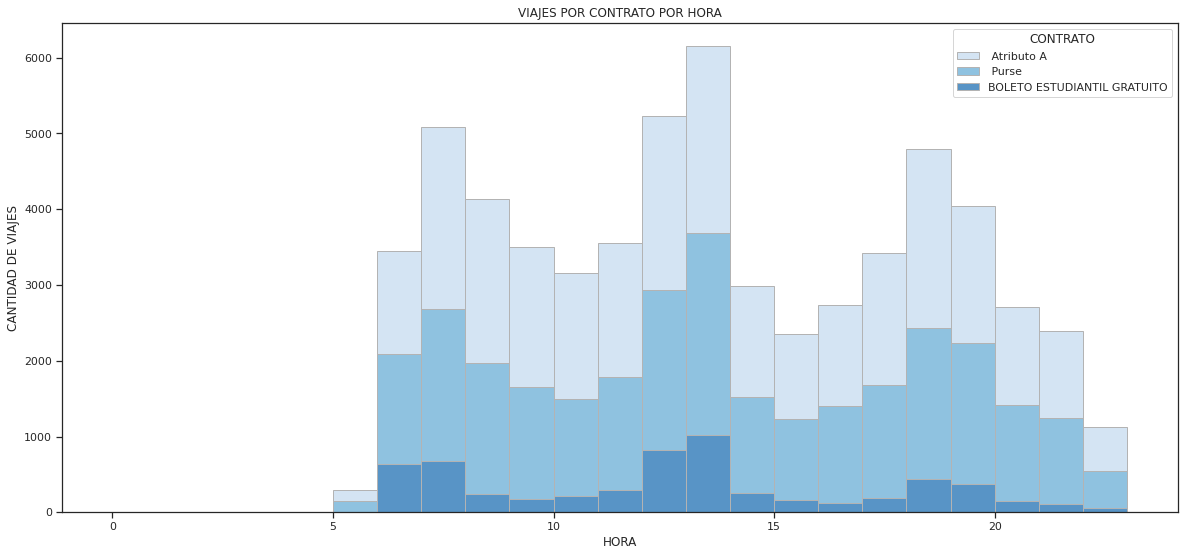

In [77]:
## Vamos a graficar la cantidad de transacciones por Contrato por Hora

sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(20, 9))

sns.histplot(
    df,
    x="HORA", hue="CONTRATO",
    multiple="stack",
    palette="Blues",
    edgecolor=".7",
    binwidth=1,
    bins=24,
    )
  
ax.set(xlabel='HORA',
       ylabel='CANTIDAD DE VIAJES',
       title='VIAJES POR CONTRATO POR HORA')

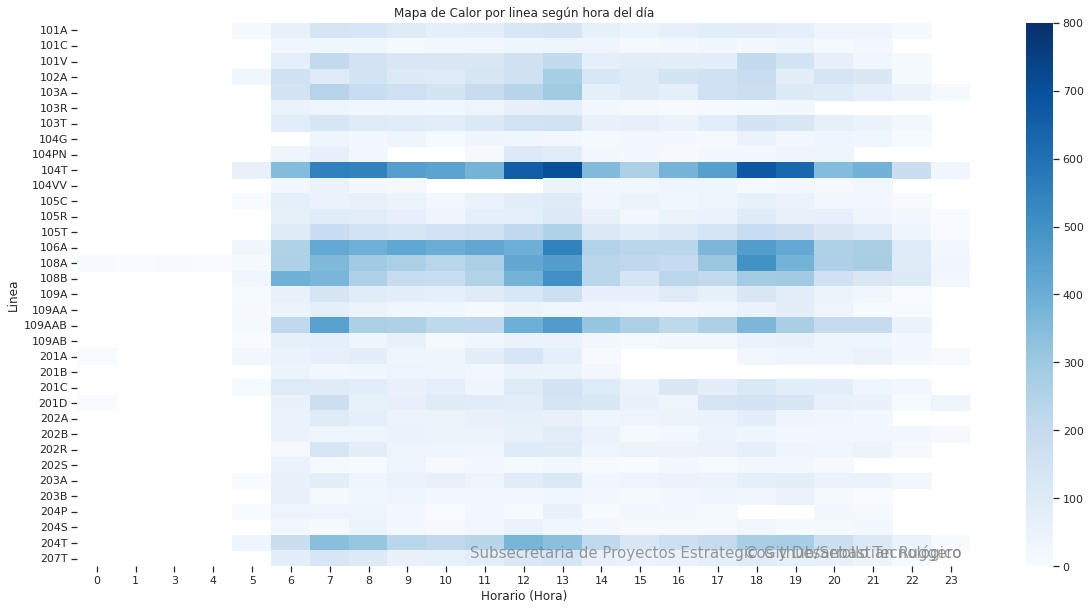

In [78]:
## Funcion para generar un Heatmap con los horarios con mas actividad

def heatmap_diario(df):

   
    # Data
    df = df.copy()
    df["hour"] = pd.DatetimeIndex(df['FECHATRX']).hour
    df["linea"] = df['DESC_RAMAL']
    daily_activity = df.groupby(by=['linea','hour']).count()['FECHATRX'].unstack()

    # Armamos la figura
    fig, ax = plt.subplots(figsize=(20,10))
    sns.heatmap(daily_activity, robust=True, vmin=0, vmax=800, cmap="Blues") # "YlOrBr

    # Asignamos las etiquetas 
    plt.xlabel("Horario (Hora)", fontsize= 12, x = 0.5)
    plt.ylabel("Linea", fontsize= 12)
    plt.title("Mapa de Calor por linea según hora del día")

    # Marca Agua
    ax.text(0.99, 0.01, '© Github/Sebastian Ruggero',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.8)   # Marca Agua
    ax.text(0.99, 0.01, 'Subsecretaria de Proyectos Estrategicos y Desarrollo Tecnológico',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.8)


heatmap_diario(df)


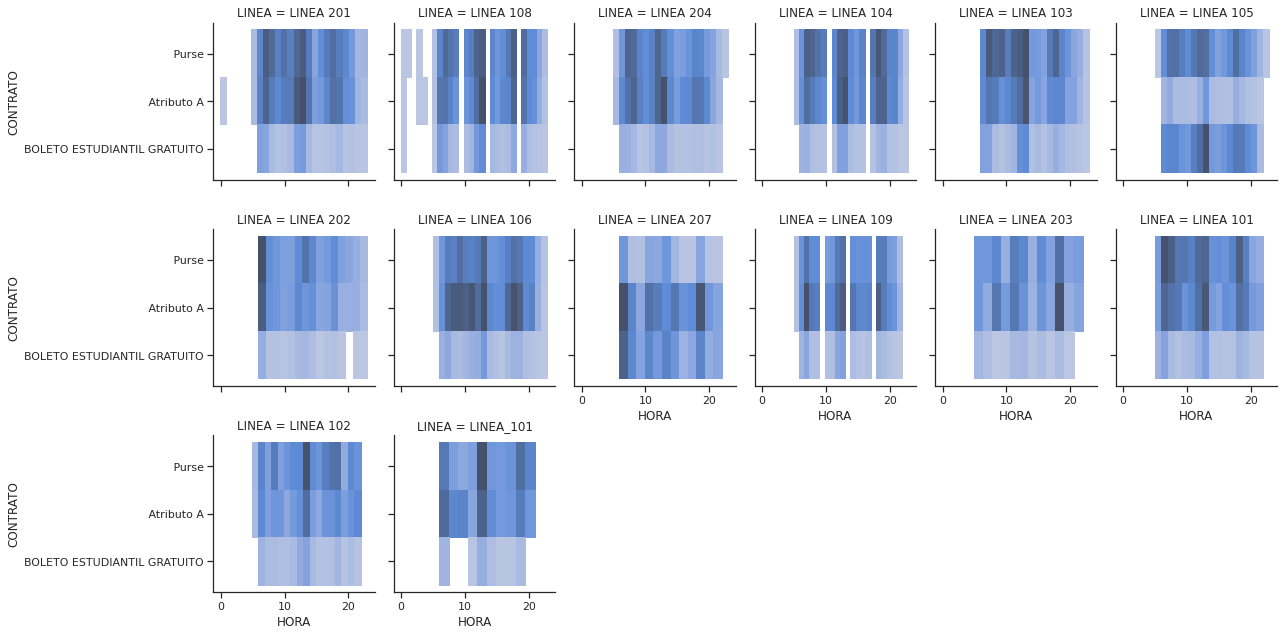

In [38]:
## Ahora vamos a graficar un mapa de calor por tipo de contrato por linea
df_filter = df[df.CONTRATO.isin([" Atributo A", " Purse", "BOLETO ESTUDIANTIL GRATUITO"])]
g = sns.FacetGrid(df_filter, col="LINEA", col_wrap=6)
g.map(sns.histplot, "HORA", "CONTRATO")


Text(0.99, 0.01, 'Subsecretaria de Proyectos Estrategicos y Desarrollo Tecnológico')

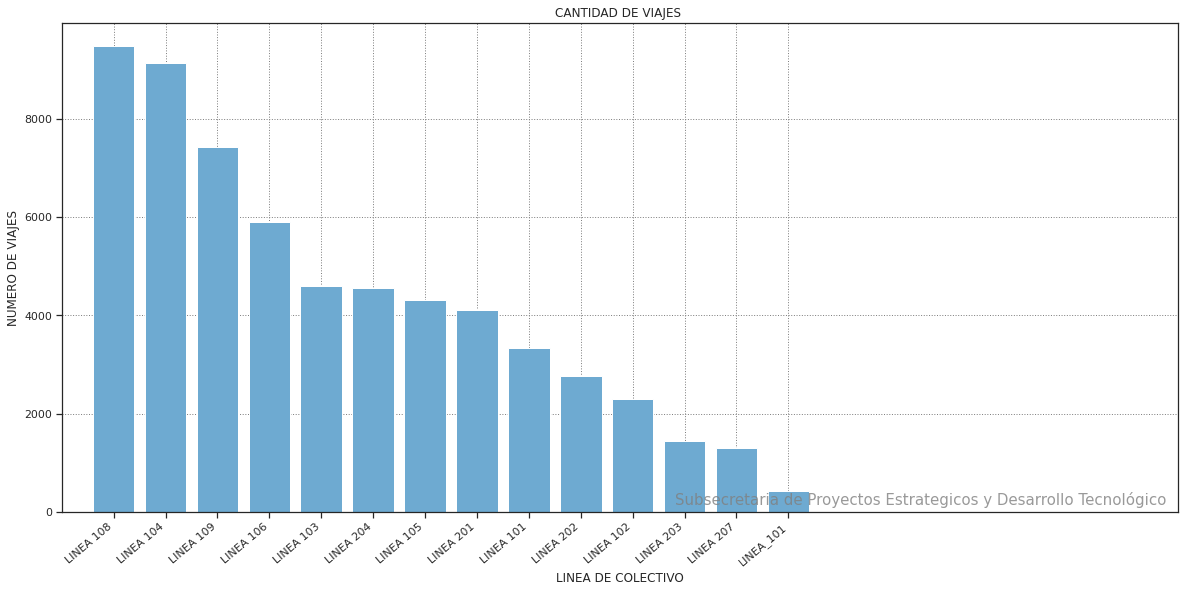

In [74]:
    """
    Función ranking de empresas por cantidad de transacciones
    """
    # Cargamos la data
    df = df.copy()
    df["hour"] = pd.DatetimeIndex(df['FECHATRX']).hour
    df["weekday"] = pd.DatetimeIndex(df['FECHATRX']).weekday
    daily_activity = df.groupby(by=['weekday','hour']).count()['FECHATRX'].unstack()

    # Dibujamos 
    fig = plt.figure(figsize=(20,9))
    ax = sns.countplot(x="LINEA" , color=BLUE, data=df, order = df['LINEA'].value_counts().index)

    # Etiquetamos 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.xlabel("LINEA DE COLECTIVO", fontsize= 12, x = 0.5)
    plt.ylabel("NUMERO DE VIAJES", fontsize= 12)
    plt.title("CANTIDAD DE VIAJES ")
    plt.xlim(-1,20.5)

    # Dibujamos la grilla
    plt.grid(linestyle=":", color='grey')

        # Marca Agua
    ax.text(0.99, 0.01, 'Subsecretaria de Proyectos Estrategicos y Desarrollo Tecnológico',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.8)




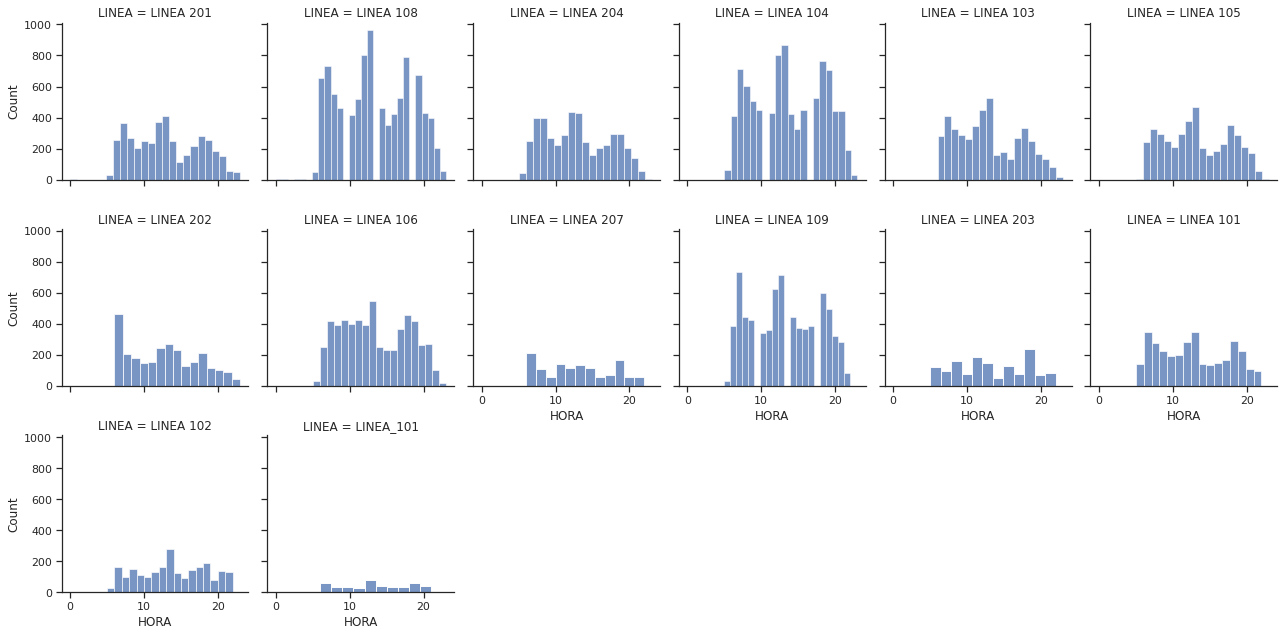

In [49]:
## Ahora vamos a ver la cantidad de transacciones abierto por linea
g = sns.FacetGrid(df, col="LINEA", col_wrap=6)
g.map(sns.histplot, "HORA")

In [80]:
## Mapa Calor

## Copiamos el dataframe
heat_df = df.copy()

## Seteamos el mapa de folium
mapa = folium.Map(location=[-28.469581, -65.779544], tiles="OpenStreetMap",zoom_start=12)

#Filtramos las condiciones y luego ar
##heat_df =dataframe[(dataframe.DESC_RAMAL =='203B')] # Filtramos por Ramal
heat_df =df[(df.CONTRATO ==' Atributo A')] # Filtramos por boleto estudiantil 
heat_df = heat_df[['LONGITUDE', 'LATITUDE']]
heat_df = heat_df.dropna(axis=0, subset=['LONGITUDE','LATITUDE'])


## Armo la lista de pos
heat_data = [[row['LATITUDE'],row['LONGITUDE']] for index, row in heat_df.iterrows()]


## Agrego la info al mapa y grafico el Mapa de Calor
HeatMap(heat_data, radius=8, blur= 5 ).add_to(mapa)

## Muestro el Mapa
mapa


## Ahora vamos a representar en ejes cartesianos las transacciones informadas Esta información nos permite estimar mediante las transacciones el recorrido real del servicio


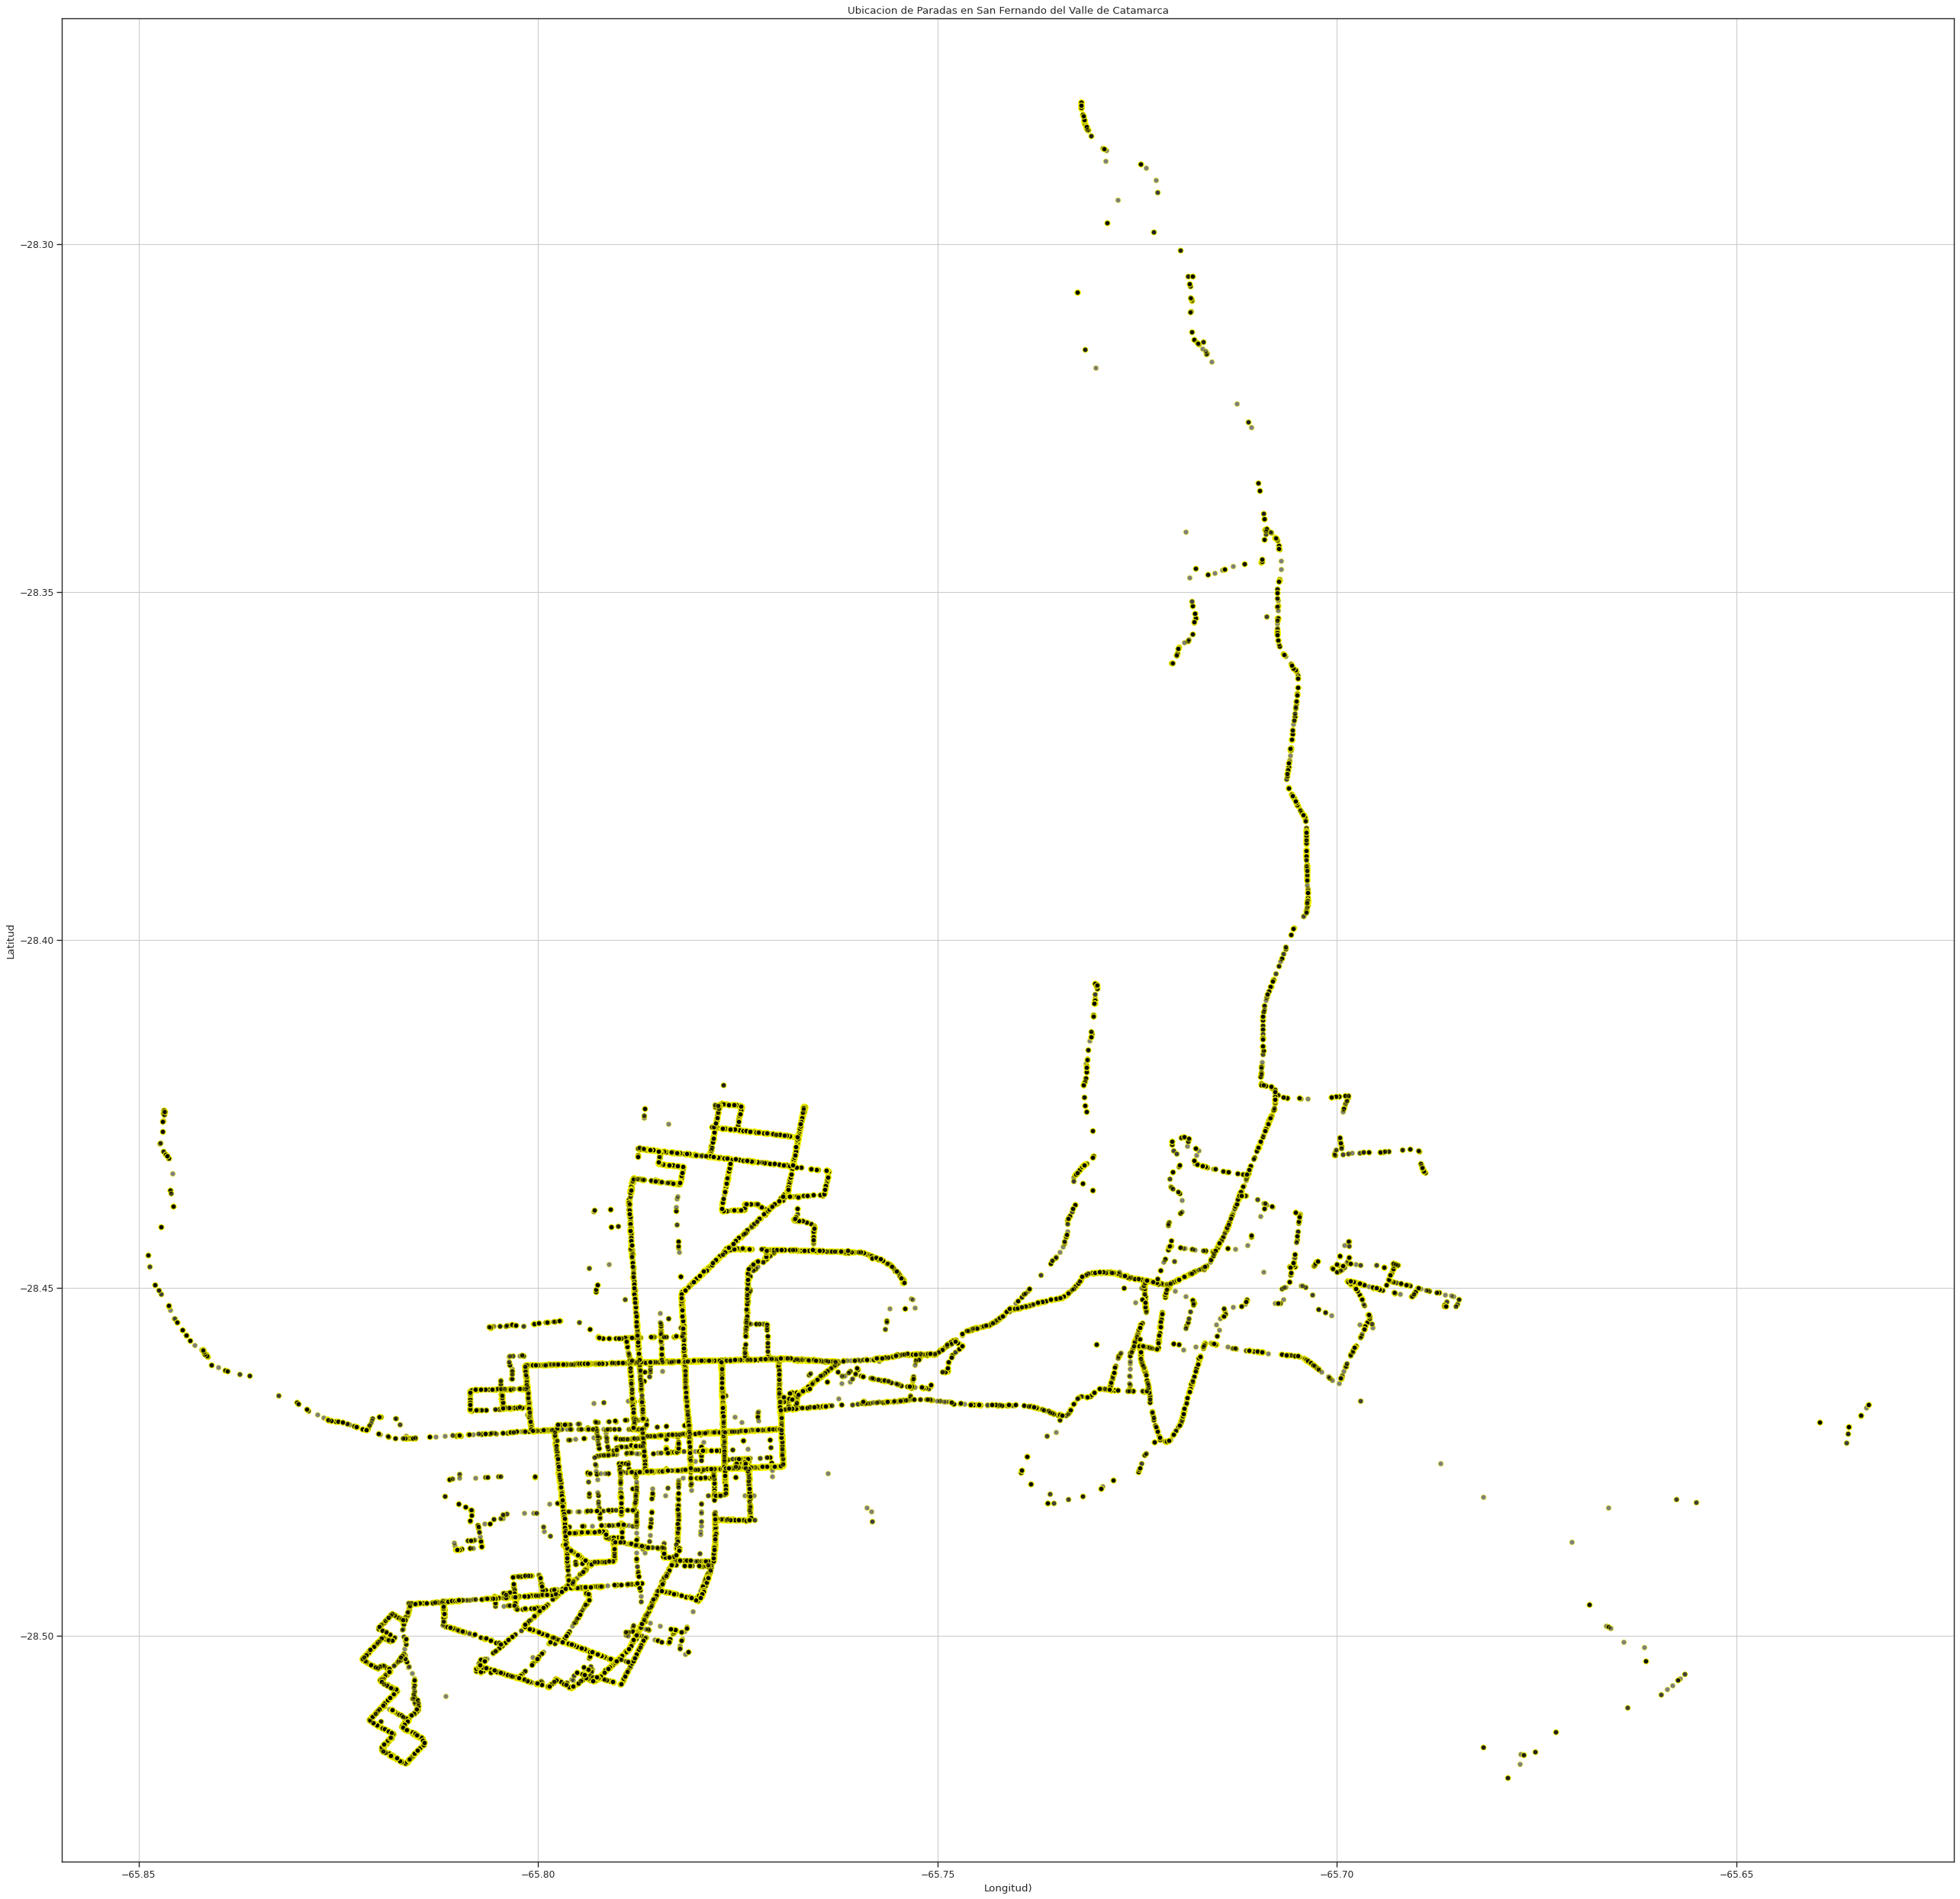

In [56]:
## Graficamos las paradas en un eje cartesiano

## Definimos el area del grafico
plt.figure(figsize=(40,40), dpi=80)

## Generamos los datos del mapa 
mapa = plt.scatter( df.LONGITUDE,
            df.LATITUDE, 
            c="black", 
            edgecolors="yellow",
            alpha=0.5)
## ostramos la grilla y las etiquetas 
plt.grid()
plt.xlabel('Longitud)')
plt.ylabel('Latitud')
plt.title('Ubicacion de Paradas en San Fernando del Valle de Catamarca')   

## Mostramos el mapa
plt.show(mapa)

## Vamos a cruzar la información con la información de los barrios populares del [RENABAP](https://https://www.argentina.gob.ar/desarrollosocial/renabap/mapa)


In [60]:
## Cargamos los set de datos de datos abiertos RENABAP
url = "https://datosabiertos.desarrollosocial.gob.ar/dataset/0d022767-9390-486a-bff4-ba53b85d730e/resource/97cc7d10-ad4c-46cb-9ee4-becb402adf9f/download/20220131_info_publica.geojson"
barrios_populares = gpd.read_file(url)
barrios_populares.head(1)

## Filtramos la provincia de Catamarca y la localidad que vamos a evaluar - En este caso la localidad de San Fernando del Valle de Catamarca en la Provincia de Catamarca
barrios_populares_catamarca = barrios_populares[(barrios_populares.Provincia =='Catamarca') & (barrios_populares.Localidad=='San Fernando Del Valle De Catamarca') ] # Filtramos por linea
barrios_populares_catamarca.head()

,id_renabap,Barrio,Provincia,Departamento \ Partido,Localidad,Año de creación,Década de creación,Electricidad,Cloaca,Agua,Gas,Familias estimadas,geometry
2498,2724,Los Médanos,Catamarca,Capital,San Fernando Del Valle De Catamarca,-,2000,Conexión irregular a la red,Conexión formal a la red cloacal,Conexión regular a la red de agua pero sin fac...,Gas en garrafa,30,"MULTIPOLYGON (((-65.76671 -28.48148, -65.76802..."
2499,2725,Papa Francisco,Catamarca,Capital,San Fernando Del Valle De Catamarca,2012,2010,Conexión irregular a la red,Desagüe sólo a pozo negro/ciego u hoyo,Conexión irregular a la red de agua,Leña o carbón,380,"MULTIPOLYGON (((-65.77995 -28.42671, -65.77794..."
2500,2726,Santa Lucía Sur,Catamarca,Capital,San Fernando Del Valle De Catamarca,-,1990,Conexión irregular a la red,Desagüe sólo a pozo negro/ciego u hoyo,Conexión irregular a la red de agua,Gas en garrafa,80,"MULTIPOLYGON (((-65.75041 -28.46627, -65.75062..."
2501,2727,Valle Hermoso,Catamarca,Capital,San Fernando Del Valle De Catamarca,2010,2010,Conexión irregular a la red,Desagüe sólo a pozo negro/ciego u hoyo,Conexión irregular a la red de agua,Gas en garrafa,50,"MULTIPOLYGON (((-65.73681 -28.45582, -65.73519..."
2502,2728,Magisterio,Catamarca,Capital,San Fernando Del Valle De Catamarca,2011,2010,Conexión formal a la red con medidor domicilia...,Desagüe sólo a pozo negro/ciego u hoyo,Conexión irregular a la red de agua,Gas en garrafa,350,"MULTIPOLYGON (((-65.77705 -28.43813, -65.77683..."


In [73]:
## Dibujamos en el mapa los poligonos Correspondiente
mapa = folium.Map(location=[-28.469581, -65.779544],  min_zoom=13, zoom_start=13)

for _, r in barrios_populares_catamarca.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['Barrio']).add_to(geo_j)
    geo_j.add_to(mapa)

mapa


## Superponemos ambos layer para poder vizualizar la actividad de transacciones en los barrios populares

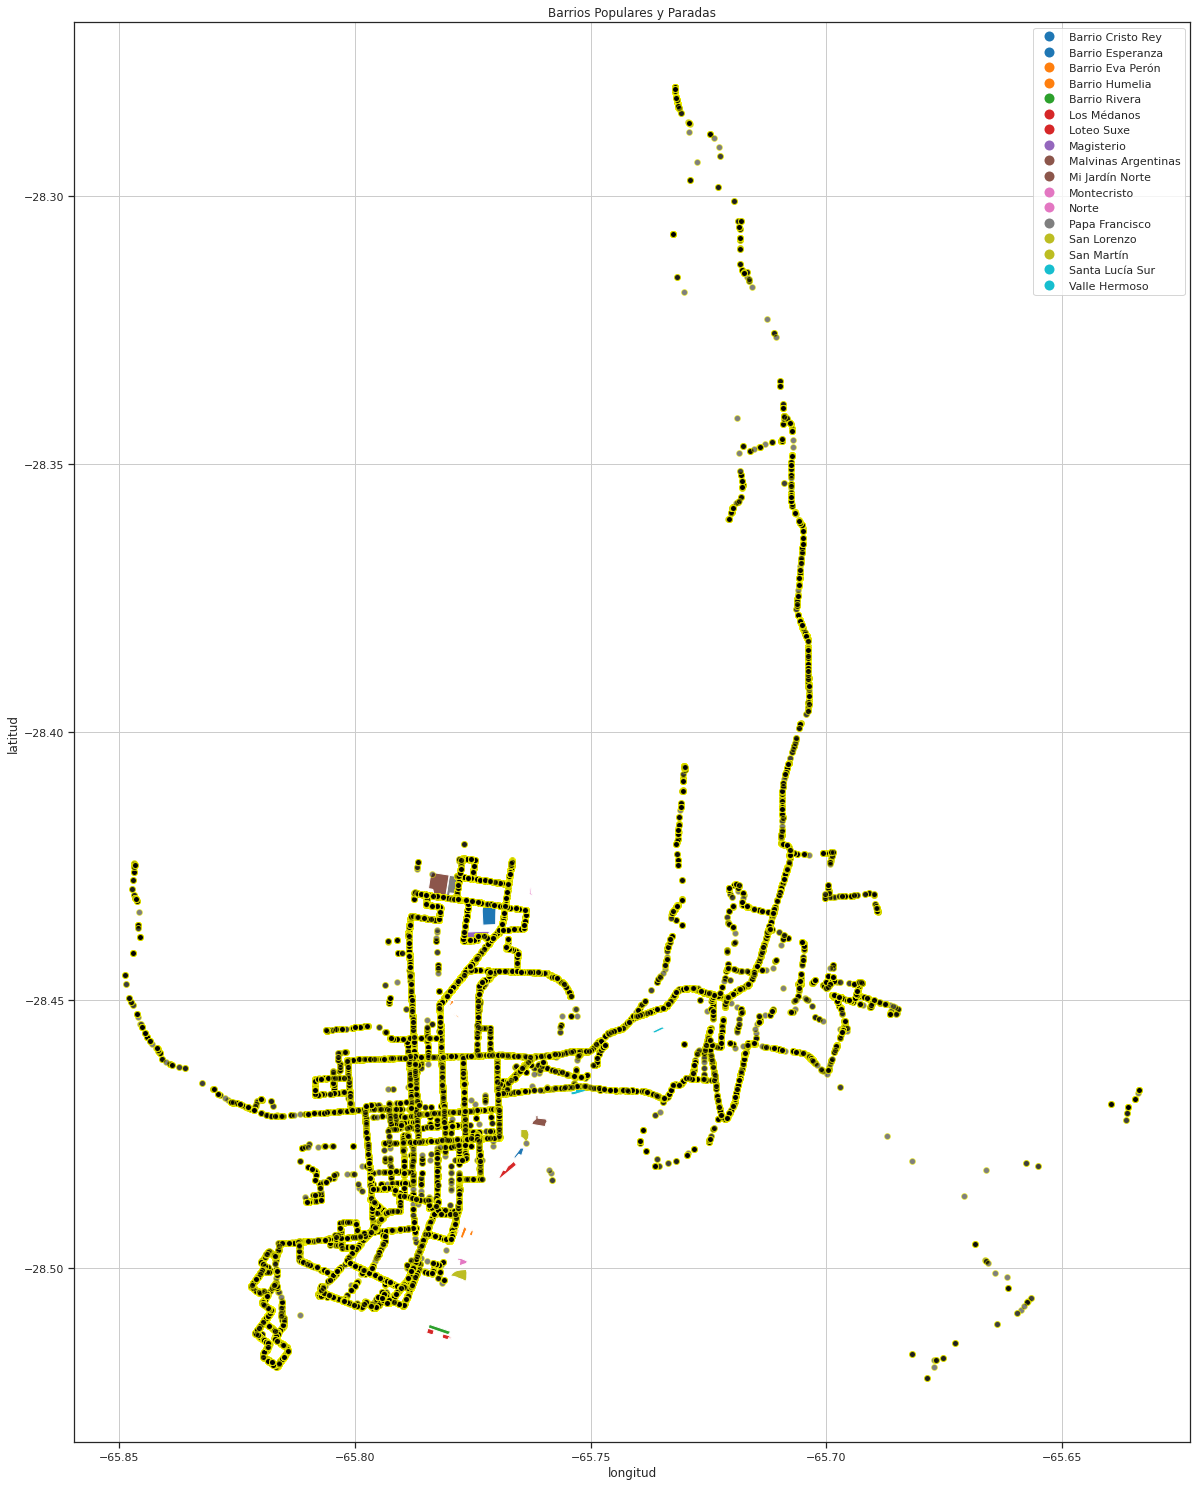

In [81]:
# Graficamos el shape junto con los recorridos para poder observar 
barrios_populares_catamarca.plot(column='Barrio', legend=True , figsize=(20,40))

# Agregamos los puntos del recorrido
plt.scatter(x=df.LONGITUDE, y=df.LATITUDE, c='black', edgecolor = 'yellow', alpha=0.5)

# Agegamos etiquetas y titulos
plt.title('Barrios Populares y Paradas')
plt.xlabel('longitud')
plt.ylabel('latitud')


# Agregamos grid y mostramos
plt.grid()
plt.show()